In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,Input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from imutils import paths
from PIL import Image
import numpy as np
import seaborn as sns

(1858, 2090)


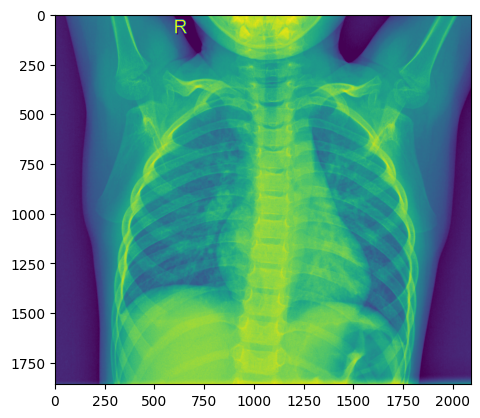

In [3]:
img = Image.open(os.path.join('train/NORMAL', 'IM-0115-0001.jpeg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img)

(439, 712, 3)


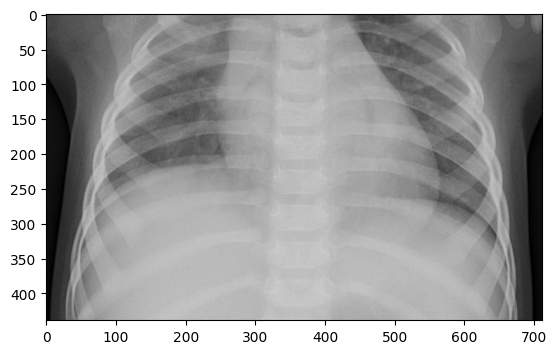

In [4]:
img = Image.open(os.path.join('train/PNEUMONIA', 'person1_bacteria_1.jpeg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img)

In [5]:
# train klasöründeki normal görsellerin ve etiket değerlerinin dizilere aktarılması
imagePaths_normal = list(paths.list_images(os.path.join('train/NORMAL')))

In [27]:
data_0 = []
labels_0 = []
for imagePath in imagePaths_normal:
    image = Image.open(imagePath)
    image = image.convert("RGB")
    image = image.resize((224, 224), Image.BILINEAR)
    data_0.append(image)
    labels_0.append(0)

In [21]:
# train klasöründeki PNEUMONIA görsellerin ve etiket değerlerinin dizilere aktarılması
imagePaths_pneumonia = list(paths.list_images(os.path.join('train/PNEUMONIA')))

In [22]:
data_1 = []
labels_1 = []
for imagePath in imagePaths_pneumonia:
    image = Image.open(imagePath)
    image = image.convert("RGB")
    image = image.resize((224, 224), Image.BILINEAR)
    data_1.append(image)
    labels_1.append(1)

In [23]:
# test klasöründeki normal görsellerin ve etiket değerlerinin dizilere aktarılması
imagePaths_normal_test = list(paths.list_images(os.path.join('test/NORMAL')))

In [37]:
data_test = []
labels_test = []
for imagePath in imagePaths_normal_test:
    image = Image.open(imagePath)
    image = image.convert("RGB")
    image = image.resize((224, 224), Image.BILINEAR)
    data_test.append(image)
    labels_test.append(0)

In [29]:
# test klasöründeki PNEUMONIA görsellerin ve etiket değerlerinin dizilere aktarılması
imagePaths_PNEUMONIA_test = list(paths.list_images(os.path.join('test/PNEUMONIA')))

In [38]:
for imagePath in imagePaths_PNEUMONIA_test:
    image = Image.open(imagePath)
    image = image.convert("RGB")
    image = image.resize((224, 224), Image.BILINEAR)
    data_test.append(image)
    labels_test.append(1)

In [31]:
# data_0 ve data_1'i birleştirme
data = np.concatenate((data_0, data_1), axis=0)

# labels_0 ve labels_1'i birleştirme
labels = np.concatenate((labels_0, labels_1), axis=0)

# Verilerin boyutunu kontrol etme
print("Combined Data Shape:", data.shape)
print("Combined Labels Shape:", labels.shape)

Combined Data Shape: (5232, 224, 224, 3)
Combined Labels Shape: (5232,)


In [32]:
# train görselleri ölçeklendirelim ve listeleri Numpy dizisine çevirelim
data = np.array(data) / 255.0
labels = np.array(labels)

In [33]:
np.unique(labels)

array([0, 1])

In [39]:
# test görsellerini ölçeklendirelim ve listeleri Numpy dizisine çevirelim
data_test = np.array(data_test) / 255.0
labels_test = np.array(labels_test)

# Verilerin boyutunu kontrol etme
print("Combined Data Shape:", data_test.shape)
print("Combined Labels Shape:", labels_test.shape)

Combined Data Shape: (624, 224, 224, 3)
Combined Labels Shape: (624,)


In [40]:
np.unique(labels_test)

array([0, 1])

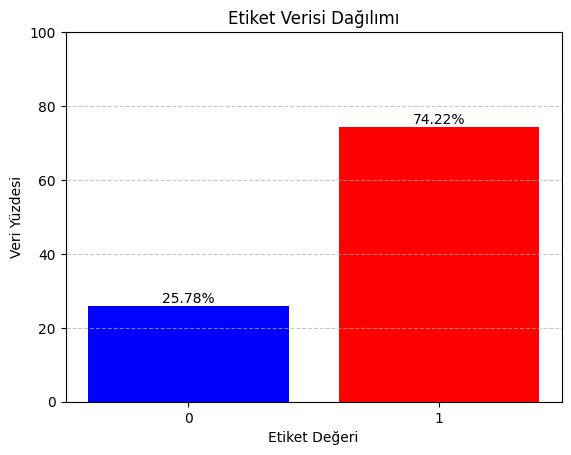

In [41]:
# labels dizisindeki 0 ve 1'lerin dağılımına bakalım
total_samples = len(labels_0)+len(labels_1)
num_zeros = len(labels_0)
num_ones = len(labels_1)

# Yüzdelik olarak dağılımı hesapla
percentage_zeros = (num_zeros / total_samples) * 100
percentage_ones = (num_ones / total_samples) * 100

# Çubuk grafik oluştur
plt.bar([0, 1], [percentage_zeros, percentage_ones], tick_label=['0', '1'], color=['blue', 'red'])
plt.xlabel('Etiket Değeri')
plt.ylabel('Veri Yüzdesi')
plt.title('Etiket Verisi Dağılımı')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Değerleri çubukların üzerine yaz
for i, value in enumerate([percentage_zeros, percentage_ones]):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center')

plt.show()

In [42]:
# veri setini %80 eğitim ve %20 validasyon verisi olarak split edelim
(X_train, X_test, y_train, y_test) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [43]:
del data_0

In [44]:
del data_1

In [45]:
del labels_0

In [46]:
del labels_1

In [47]:
del data

In [48]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [49]:
datagen.fit(X_train)

# ANN

In [50]:
# Yapay sinir ağı modelini oluşturma
model_ann = Sequential()
model_ann.add(Input(shape=(224, 224,3)))  # Giriş katmanı
model_ann.add(Flatten())  # Düzleştirme katmanı
model_ann.add(Dense(128, activation='relu'))  # Gizli katman
model_ann.add(Dense(256, activation='relu'))  # Gizli katman
model_ann.add(Dense(64, activation='relu'))  # Gizli katman
model_ann.add(Dropout(0.2)) # Dropout katmanı ekleme
model_ann.add(Dense(1, activation='sigmoid'))  # Çıkış katmanı

In [51]:
# Adam optimize edici oluşturma ve öğrenme oranı belirleme
optimizer = Adam(learning_rate=0.001)

In [52]:
# Modeli derleme
model_ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
# Modeli eğitme
history_ann=model_ann.fit(datagen.flow(X_train,y_train, batch_size = 32), epochs=10, validation_data=datagen.flow(X_test, y_test))

Epoch 1/10


131/131 [==============================] - 35s 261ms/step - loss: 2.4931 - accuracy: 0.6941 - val_loss: 0.5690 - val_accuracy: 0.7421
Epoch 2/10
131/131 [==============================] - 35s 266ms/step - loss: 0.5663 - accuracy: 0.7422 - val_loss: 0.5221 - val_accuracy: 0.7421
Epoch 3/10
131/131 [==============================] - 35s 265ms/step - loss: 0.5157 - accuracy: 0.7422 - val_loss: 0.4686 - val_accuracy: 0.7421
Epoch 4/10
131/131 [==============================] - 34s 263ms/step - loss: 0.4823 - accuracy: 0.7422 - val_loss: 0.4571 - val_accuracy: 0.7469
Epoch 5/10
131/131 [==============================] - 35s 266ms/step - loss: 0.4777 - accuracy: 0.7515 - val_loss: 0.4193 - val_accuracy: 0.7956
Epoch 6/10
131/131 [==============================] - 35s 266ms/step - loss: 0.5068 - accuracy: 0.7434 - val_loss: 0.4358 - val_accuracy: 0.7421
Epoch 7/10
131/131 [==============================] - 35s 265ms/step - loss: 0.4748 - accuracy: 0.7417 - val_loss: 0.4668 - val_

In [54]:
# Eğitim sürecindeki kayıp değerlerini alın
train_loss_ann = history_ann.history['loss']
val_loss_ann = history_ann.history['val_loss']

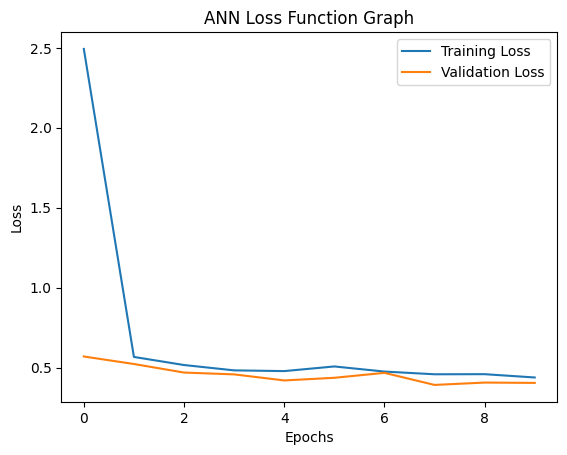

In [55]:
# Kayıp değerlerini çizdirme
plt.plot(train_loss_ann, label='Training Loss')
plt.plot(val_loss_ann, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN Loss Function Graph')
plt.show()

In [56]:
# Test veri kümesi üzerinde tahmin yapma
y_pred_prob_ann = model_ann.predict(X_test)
y_pred_ann = np.round(y_pred_prob_ann).astype(int)

33/33 [==============================] - 0s 9ms/step


In [57]:
# Sınıflandırma raporunu oluşturma
print('ANN Ağı Sınıflandırma Raporu')
print(classification_report(y_test, y_pred_ann))

ANN Ağı Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       270
           1       0.96      0.87      0.91       777

    accuracy                           0.88      1047
   macro avg       0.83      0.88      0.85      1047
weighted avg       0.90      0.88      0.88      1047



In [58]:
# Confusion matrix'i hesapla
cm_ann = confusion_matrix(y_test, y_pred_ann)

In [59]:
# Etiketlerin adlarını belirle
cm_labels = ['NORMAL', 'PNEUMONIA']

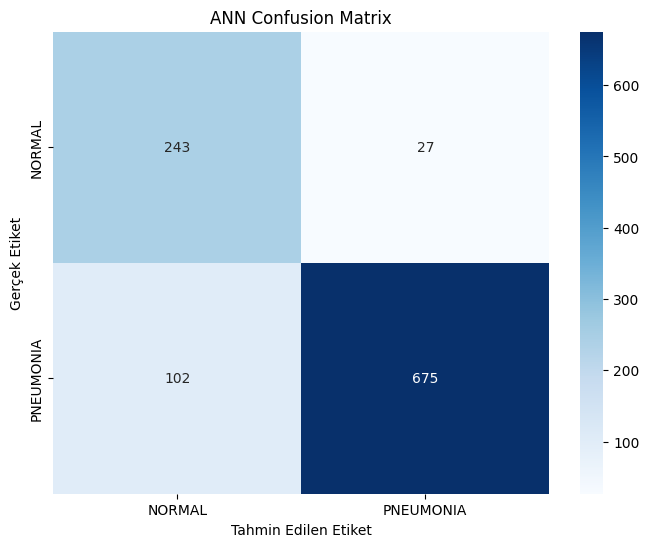

In [60]:
# Heatmap çizimi
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('ANN Confusion Matrix')
plt.show()

In [61]:
# ROC eğrisi oluşturma
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_prob_ann)
roc_auc_ann = auc(fpr_ann, tpr_ann)

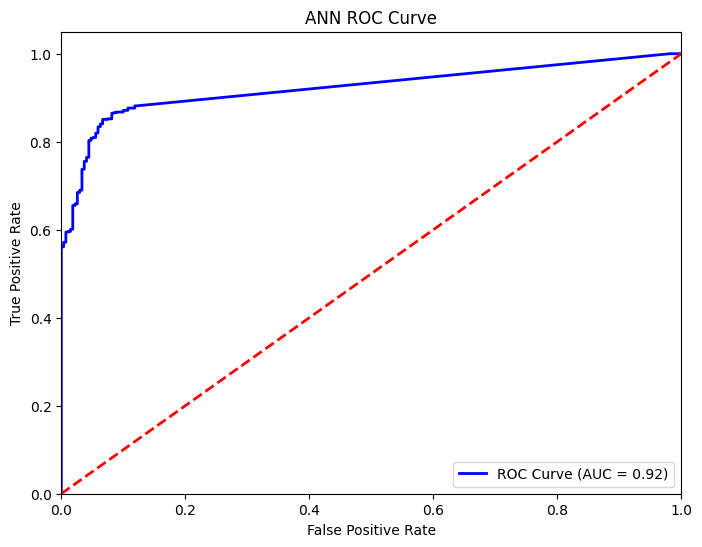

In [62]:
# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_ann)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [63]:
# daha önce hiç görmediği veri kümesi üzerinde tahmin yapma
y_pred_prob_test_ann = model_ann.predict(data_test)
y_pred_test_ann = np.round(y_pred_prob_test_ann).astype(int)

20/20 [==============================] - 0s 9ms/step


In [64]:
# Sınıflandırma raporunu oluşturma
print('ANN Ağı Sınıflandırma Raporu (Test)')
print(classification_report(labels_test, y_pred_test_ann))

ANN Ağı Sınıflandırma Raporu (Test)
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       234
           1       0.87      0.86      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.82      0.82       624
weighted avg       0.83      0.83      0.83       624



In [65]:
# Confusion matrix'i hesapla
cm_test_ann = confusion_matrix(labels_test, y_pred_test_ann)

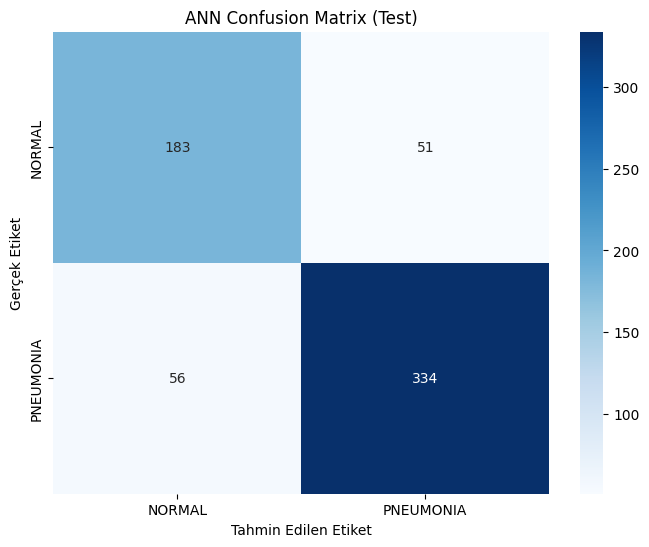

In [66]:
# Heatmap çizimi
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_ann, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('ANN Confusion Matrix (Test)')
plt.show()

In [67]:
# ROC eğrisi oluşturma
fpr_test_ann, tpr_test_ann, thresholds_test_ann = roc_curve(labels_test, y_pred_prob_test_ann)
roc_auc_test_ann = auc(fpr_test_ann, tpr_test_ann)

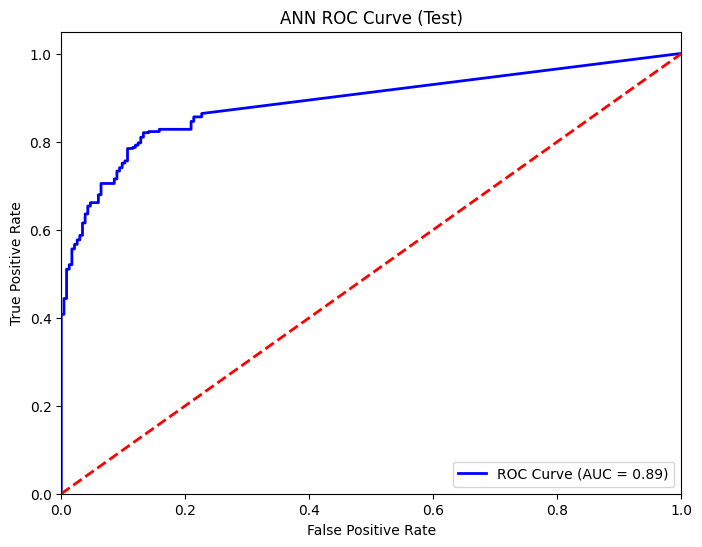

In [68]:
# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_ann, tpr_test_ann, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_test_ann)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN ROC Curve (Test)')
plt.legend(loc="lower right")
plt.show()

# CNN

In [69]:
# Modeli oluşturun
model_cnn = Sequential()
model_cnn.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,3)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_cnn.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_cnn.add(Dropout(0.1))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_cnn.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_cnn.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_cnn.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_cnn.add(Flatten())
model_cnn.add(Dense(units = 128 , activation = 'relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(units = 1 , activation = 'sigmoid'))

In [70]:
model_cnn.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [71]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)     

In [72]:
# Modeli eğitin
H_cnn=model_cnn.fit(datagen.flow(X_train,y_train, batch_size = 32) , epochs=10, validation_data=datagen.flow(X_test, y_test))

Epoch 1/10
131/131 [==============================] - 148s 1s/step - loss: 0.8871 - accuracy: 0.8045 - val_loss: 19.2013 - val_accuracy: 0.7421
Epoch 2/10
131/131 [==============================] - 151s 1s/step - loss: 0.3404 - accuracy: 0.8784 - val_loss: 21.6572 - val_accuracy: 0.7421
Epoch 3/10
131/131 [==============================] - 149s 1s/step - loss: 0.2735 - accuracy: 0.9001 - val_loss: 5.0181 - val_accuracy: 0.7421
Epoch 4/10
131/131 [==============================] - 270s 2s/step - loss: 0.2363 - accuracy: 0.9123 - val_loss: 0.4410 - val_accuracy: 0.8816
Epoch 5/10
131/131 [==============================] - 316s 2s/step - loss: 0.2235 - accuracy: 0.9214 - val_loss: 0.4141 - val_accuracy: 0.8367
Epoch 6/10
131/131 [==============================] - 145s 1s/step - loss: 0.2147 - accuracy: 0.9281 - val_loss: 16.0677 - val_accuracy: 0.7450
Epoch 7/10
131/131 [==============================] - 148s 1s/step - loss: 0.2092 - accuracy: 0.9243 - val_loss: 0.4400 - val_accuracy: 0.8

In [73]:
# Eğitim sürecindeki kayıp değerlerini alın
train_loss_cnn = H_cnn.history['loss']
val_loss_cnn = H_cnn.history['val_loss']

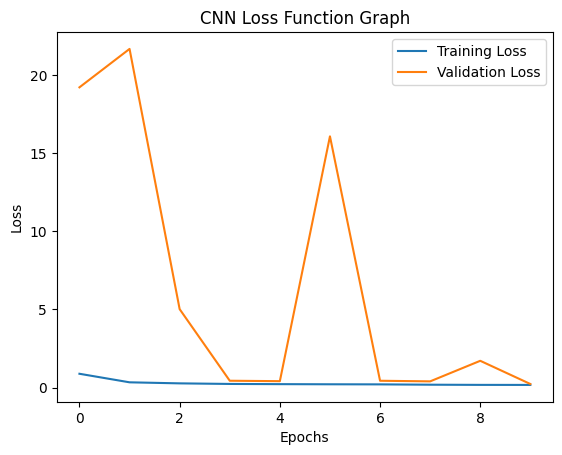

In [74]:
# Kayıp değerlerini çizdirme
plt.plot(train_loss_cnn, label='Training Loss')
plt.plot(val_loss_cnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Loss Function Graph')
plt.show()

In [75]:
# Test veri kümesi üzerinde tahmin yapma
y_pred_prob_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.round(y_pred_prob_cnn).astype(int)

33/33 [==============================] - 7s 218ms/step


In [76]:
# Sınıflandırma raporunu oluşturma
print('CNN Ağı Sınıflandırma Raporu')
print(classification_report(y_test, y_pred_cnn))

CNN Ağı Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.95      0.70      0.80       270
           1       0.90      0.99      0.94       777

    accuracy                           0.91      1047
   macro avg       0.93      0.84      0.87      1047
weighted avg       0.92      0.91      0.91      1047



In [77]:
# Confusion matrix'i hesapla
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

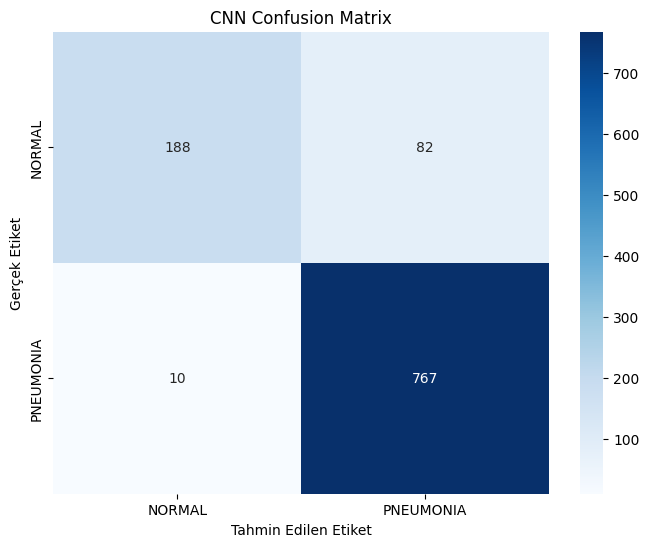

In [78]:
# Heatmap çizimi
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('CNN Confusion Matrix')
plt.show()

In [79]:
# ROC eğrisi oluşturma
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

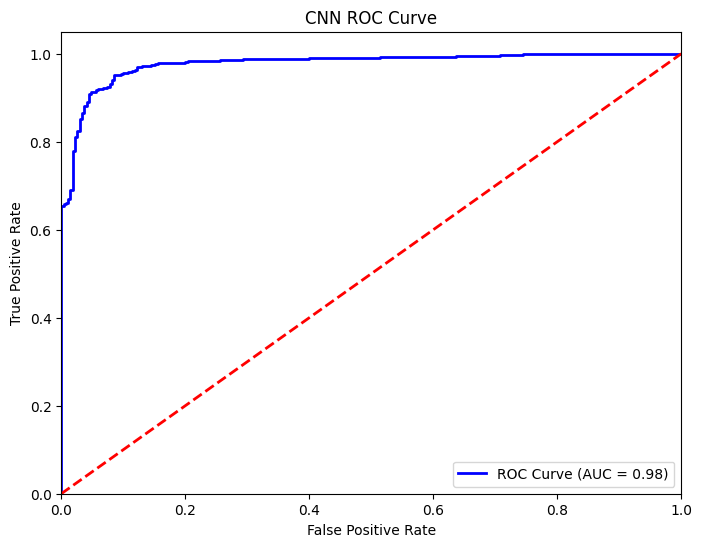

In [80]:
# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_cnn)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [81]:
# daha önce hiç görmediği veri kümesi üzerinde tahmin yapma
y_pred_prob_test_cnn = model_cnn.predict(data_test)
y_pred_test_cnn = np.round(y_pred_prob_test_cnn).astype(int)

20/20 [==============================] - 4s 214ms/step


In [82]:
# Sınıflandırma raporunu oluşturma
print('CNN Ağı Sınıflandırma Raporu (Test)')
print(classification_report(labels_test, y_pred_test_cnn))

CNN Ağı Sınıflandırma Raporu (Test)
              precision    recall  f1-score   support

           0       0.95      0.35      0.51       234
           1       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



In [83]:
# Confusion matrix'i hesapla
cm_test_cnn = confusion_matrix(labels_test, y_pred_test_cnn)

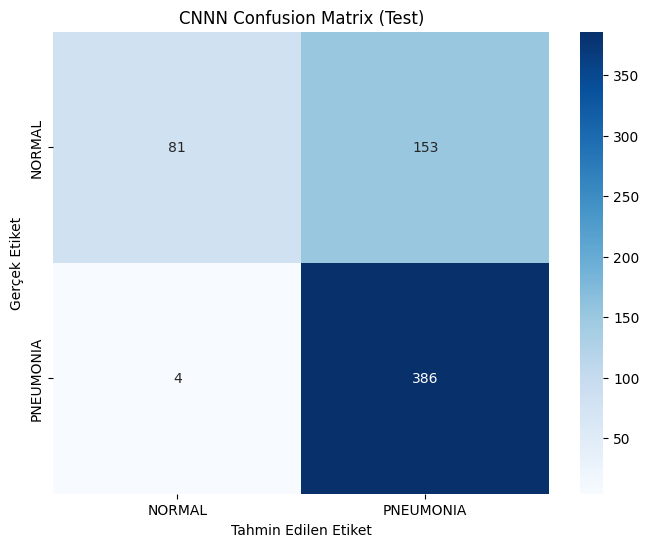

In [84]:
# Heatmap çizimi
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('CNNN Confusion Matrix (Test)')
plt.show()

In [85]:
# ROC eğrisi oluşturma
fpr_test_cnn, tpr_test_cnn, thresholds_test_cnn = roc_curve(labels_test, y_pred_prob_test_cnn)
roc_auc_test_cnn = auc(fpr_test_cnn, tpr_test_cnn)

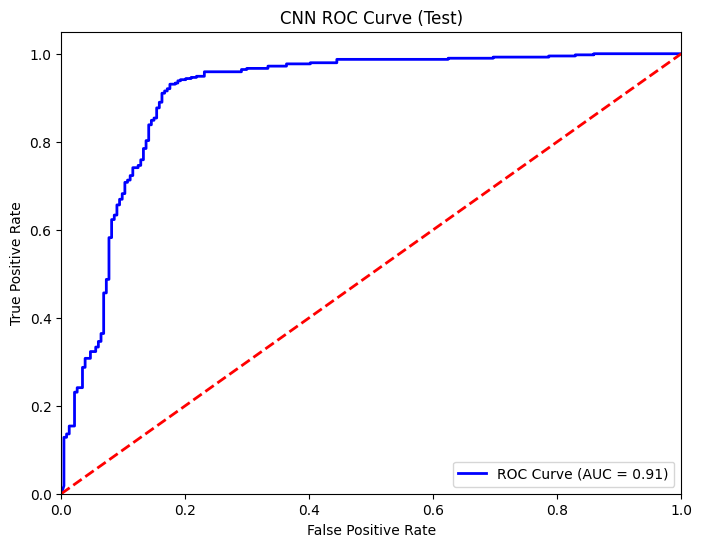

In [86]:
# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_cnn, tpr_test_cnn, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_test_cnn)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve (Test)')
plt.legend(loc="lower right")
plt.show()

# VGG16

In [87]:
# VGG16 ağını yükleyerek FC katman setlerinin kapalı kalmasını sağlayalım
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [88]:
# baseModel üzerine yerleştirilecek classifier modelini oluşturalım
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu", name='fc1')(headModel)
headModel = Dense(64, activation="relu", name='fc2')(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1, activation="sigmoid", name='predictions')(headModel)

In [89]:
# oluşturduğumuz FC classifier katmanını baseModel üzerine yerleştirelim
model = Model(inputs=baseModel.input, outputs=headModel)

In [90]:
# VGG16 modelinin evrişim tabanındaki tüm katmanları donduralım
for layer in baseModel.layers:
    layer.trainable = False

In [91]:
# hiperparametrelerimizi ayarlayalım
lr = 0.001 
epoch = 6
bs = 32

In [92]:
opt = Adam(learning_rate=lr)

In [93]:
# modeli compile edelim
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [94]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [95]:
# modelimizi çalıştıralım bakalım neler yapacak
H_VGG16 = model.fit(
    datagen.flow(X_train, y_train, batch_size=bs),
    steps_per_epoch=len(X_train) // bs,
    validation_data=datagen.flow(X_test, y_test, batch_size=bs),
    validation_steps=len(X_test) // bs,
    epochs=epoch
)

Epoch 1/6
130/130 [==============================] - 344s 3s/step - loss: 0.2851 - accuracy: 0.8777 - val_loss: 0.3182 - val_accuracy: 0.8555
Epoch 2/6
130/130 [==============================] - 347s 3s/step - loss: 0.1875 - accuracy: 0.9258 - val_loss: 0.1905 - val_accuracy: 0.9170
Epoch 3/6
130/130 [==============================] - 341s 3s/step - loss: 0.1549 - accuracy: 0.9425 - val_loss: 0.1187 - val_accuracy: 0.9541
Epoch 4/6
130/130 [==============================] - 348s 3s/step - loss: 0.1404 - accuracy: 0.9446 - val_loss: 0.1165 - val_accuracy: 0.9551
Epoch 5/6
130/130 [==============================] - 350s 3s/step - loss: 0.1423 - accuracy: 0.9470 - val_loss: 0.1380 - val_accuracy: 0.9502
Epoch 6/6
130/130 [==============================] - 355s 3s/step - loss: 0.1452 - accuracy: 0.9425 - val_loss: 0.1568 - val_accuracy: 0.9209


In [96]:
# Eğitim sürecindeki kayıp değerlerini alın
train_loss_VGG16= H_VGG16.history['loss']
val_loss_VGG16 = H_VGG16.history['val_loss']

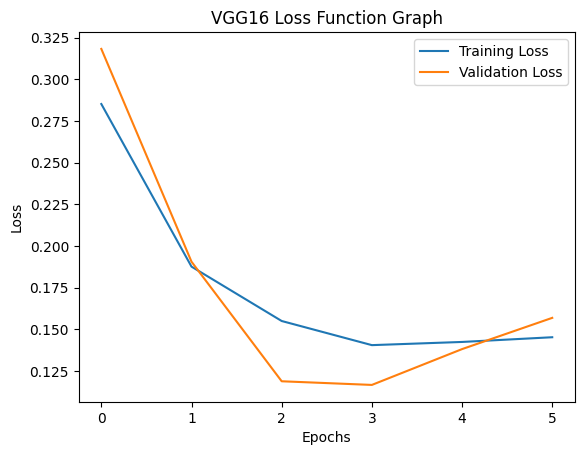

In [97]:
# Kayıp değerlerini çizdirme
plt.plot(train_loss_VGG16, label='Training Loss')
plt.plot(val_loss_VGG16, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('VGG16 Loss Function Graph')
plt.show()

In [98]:
# Test veri kümesi üzerinde tahmin yapma
y_pred_prob_VGG16 = model.predict(X_test)
y_pred_VGG16 = np.round(y_pred_prob_VGG16).astype(int)

33/33 [==============================] - 67s 2s/step


In [99]:
# Sınıflandırma raporunu oluşturma
print('VGG16 Ağı Sınıflandırma Raporu')
print(classification_report(y_test, y_pred_VGG16))

VGG16 Ağı Sınıflandırma Raporu
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       270
           1       0.95      0.99      0.97       777

    accuracy                           0.95      1047
   macro avg       0.96      0.92      0.94      1047
weighted avg       0.95      0.95      0.95      1047



In [100]:
# Confusion matrix'i hesapla
cm_VGG16 = confusion_matrix(y_test, y_pred_VGG16)

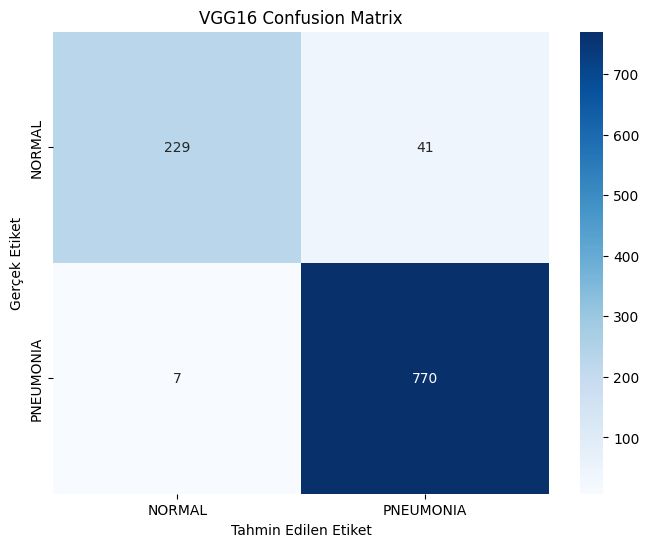

In [101]:
# Heatmap çizimi
plt.figure(figsize=(8, 6))
sns.heatmap(cm_VGG16, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('VGG16 Confusion Matrix')
plt.show()

In [102]:
# ROC eğrisi oluşturma
fpr_VGG16, tpr_VGG16, thresholds_VGG16 = roc_curve(y_test, y_pred_prob_VGG16)
roc_auc_VGG16 = auc(fpr_VGG16, tpr_VGG16)

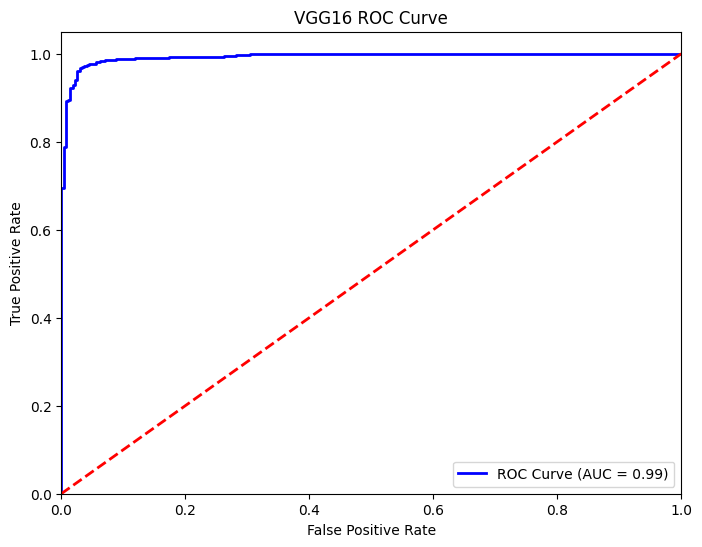

In [103]:
# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr_VGG16, tpr_VGG16, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc_VGG16)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [104]:
# daha önce hiç görmediği veri kümesi üzerinde tahmin yapma
y_pred_prob_test_VGG16 = model.predict(data_test)
y_pred_test_VGG16 = np.round(y_pred_prob_test_VGG16).astype(int)

20/20 [==============================] - 39s 2s/step


In [105]:
# Sınıflandırma raporunu oluşturma
print('VGG16 Ağı Sınıflandırma Raporu (Test)')
print(classification_report(labels_test, y_pred_test_VGG16))

VGG16 Ağı Sınıflandırma Raporu (Test)
              precision    recall  f1-score   support

           0       0.99      0.44      0.61       234
           1       0.75      1.00      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.73       624
weighted avg       0.84      0.79      0.77       624



In [106]:
# Confusion matrix'i hesapla
cm_test_VGG16 = confusion_matrix(labels_test, y_pred_test_VGG16)

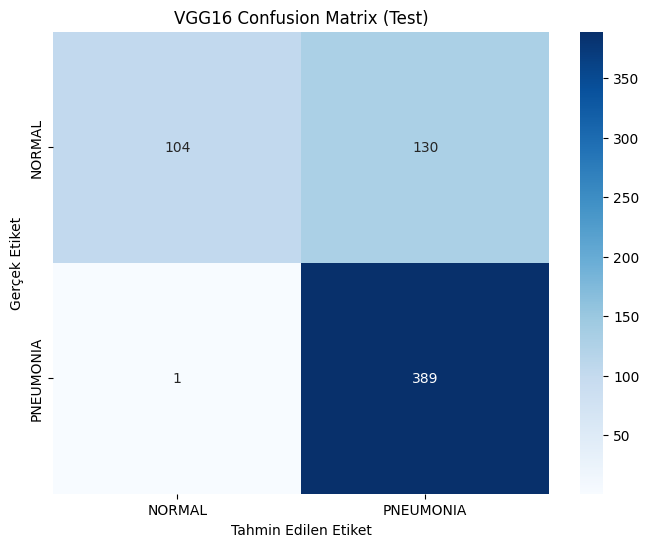

In [107]:
# Heatmap çizimi
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_VGG16, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('VGG16 Confusion Matrix (Test)')
plt.show()

In [108]:
# ROC eğrisi oluşturma
fpr_test_VGG16, tpr_test_VGG16, thresholds_test_VGG16 = roc_curve(labels_test, y_pred_prob_test_VGG16)
roc_auc_test_VGG16 = auc(fpr_test_VGG16, tpr_test_VGG16)

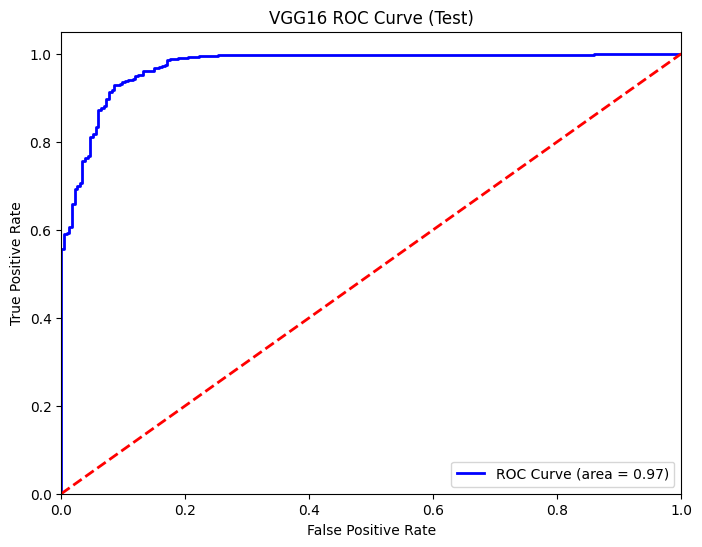

In [109]:
# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_VGG16, tpr_test_VGG16, color='blue', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc_test_VGG16)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 ROC Curve (Test)')
plt.legend(loc="lower right")
plt.show()